In [1]:
from config import *
import numpy as np
import weighted

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
import scipy.stats as stats
import numpy as np

%matplotlib inline

In [17]:
print(f'{year}年{month:02}月')

2021年01月


In [18]:
import pandas as pd
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
import sys
sys.path.append('../../py')
import db

In [19]:
conn=db.get_conn()

In [20]:
sql = f"select * from jobs where year_month={year}{month:02} and monthly_salary>0"
sql

'select * from jobs where year_month=202101 and monthly_salary>0'

In [21]:
df = pd.read_sql(sql, conn)

In [22]:
df['valid']=False

In [23]:
careers = df['career'].unique()

In [24]:
careers

array(['软件工程师', 'Android开发工程师', '算法工程师', '系统分析员', '嵌入式软件开发', 'MES',
       '系统架构设计师', 'Web前端开发', '架构师', '驱动工程师', '游戏开发工程师', 'Unity3D',
       '移动开发工程师', '人工智能', '大数据开发工程师', '大数据', '编译器开发工程师', '机器人', 'ETL',
       '视觉软件工程师', 'GIS', '技术主管', 'HTML5开发工程师', '机器视觉工程师', '数据分析经理主管',
       '图像处理工程师', 'iOS开发工程师', 'Cocos2d-x开发工程师', '数据分析师', '数据',
       '自然语言处理（NLP）', 'CAE', 'DSP', '网站架构设计师', '分布式', 'Hadoop工程师',
       '小程序开发工程师', '信号处理', '区块链开发', 'ETL开发工程师', '机器学习', '数据治理工程师',
       '图像算法工程师', 'BI工程师', 'Unity3d开发工程师', '爬虫开发工程师', '芯片', '游戏服务端开发工程师',
       '数据采集工程师', '深度学习工程师', '反作弊算法工程师', '数据仓库工程师', '搜索算法工程师', '生物信息',
       '遥感', 'CTO', '数据建模工程师', '游戏客户端开发工程师', '数据科学家', '图像识别工程师', 'ADAS',
       '语音识别工程师', 'SLAM', '前端开发', '推荐算法工程师', '敏捷教练'], dtype=object)

In [26]:
df_career = pd.DataFrame()
for career in careers:
    idf = df[df['career']==career]
    tmp=np.percentile(idf['monthly_salary'], [2, 50, 98])
    salary_min=tmp[0]
    salary_median=tmp[1]
    salary_max=tmp[2]
    df_career=df_career.append({"职能":career,"最低工资":salary_min, "中位数":salary_median, "最高工资":salary_max}, ignore_index=True)
    df.loc[((df['career']==career) & (df['monthly_salary']>=salary_min) & (df['monthly_salary']<=salary_max)), 'valid']=True

In [28]:
df_career[['职能', '中位数', '最低工资', '最高工资']].style.format({"中位数":"{:.0f}","最低工资":"{:.0f}","最高工资":"{:.0f}"})

,职能,中位数,最低工资,最高工资
0,软件工程师,12500,5250,32500
1,Android开发工程师,13500,6000,33947
2,算法工程师,20000,7000,45000
3,系统分析员,11500,3750,32900
4,嵌入式软件开发,13500,5500,30000
5,MES,12000,6000,23708
6,系统架构设计师,17500,5250,45500
7,Web前端开发,12500,5250,27500
8,架构师,25000,9000,60000
9,驱动工程师,17500,8500,33336


In [29]:
salary_mean=df[df['valid']==True]['monthly_salary'].mean()
salary_median=df[df['valid']==True]['monthly_salary'].median()


In [30]:
salary_mean

14579.781037976174

In [31]:
salary_median

12500.0

In [32]:
df=df[df['valid']==True]

In [33]:
ht=df['headcount'].sum()
salary_min=df['monthly_salary'].min()
salary_max=df['monthly_salary'].max()

In [34]:
print(f"{year}年{month}月全国招收程序员{ht}人。{year}年{month}月全国程序员平均工资{salary_mean:0.0f}元，工资中位数{salary_median:0.0f}元，其中96%的人的工资介于{salary_min:.0f}元到{salary_max:.0f}元。")

2021年1月全国招收程序员352948人。2021年1月全国程序员平均工资14580元，工资中位数12500元，其中96%的人的工资介于3500元到85000元。


# City

In [35]:
cities = ['北京','上海','深圳','杭州','广州','南京','苏州','成都','东莞','西安','武汉','天津','长沙',
'宁波','福州','大连','重庆','青岛','济南','合肥','长春','昆明','郑州','沈阳','哈尔滨','厦门']
df_city = df[df['city'].isin(cities)]

In [36]:
weighted.quantile

<function wquantiles.quantile(data, weights, quantile)>

In [37]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        
        q=[0,0,0]
        
        q[0] = weighted.quantile(values,weights,0.005)
        q[1] = weighted.quantile(values,weights,0.5)
        q[2] = weighted.quantile(values,weights,0.995)

        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['平均工资']=salary_mean
    sub_data['最低工资']=salary_95_min
    sub_data['中位数']=salary_median
    sub_data['最高工资']=salary_95_max
    sub_data['招聘人数']=count
    sub_data['百分比']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='平均工资', ascending=False)

    return sub_data

data_format={"百分比":"{:.2%}","平均工资":"{:.0f}","中位数":"{:.0f}","最低工资":"{:.0f}","最高工资":"{:.0f}"}

translate_dict={}


In [38]:
data_city=get_sub_stats_by_col(df_city,'city')
data_city['排名']=list(range(1,data_city.shape[0]+1))
data_city=data_city[['排名', 'city', '平均工资', '最低工资', '中位数', '最高工资', '招聘人数', '百分比']]
data_city.style.format(data_format)

,排名,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
12,1,北京,17870,5813,16500,45000,28076,8.79%
0,2,上海,17369,5750,16500,45000,59712,18.70%
2,3,深圳,17263,5750,15500,45000,51306,16.07%
9,4,杭州,15938,5250,15000,45000,17697,5.54%
1,5,南京,14225,5250,12500,31250,16449,5.15%
10,6,广州,14056,5000,12500,35000,34531,10.82%
7,7,苏州,13504,5250,12500,30978,10045,3.15%
14,8,东莞,12987,5000,12500,30000,3829,1.20%
3,9,成都,12749,3750,12500,31250,17302,5.42%
17,10,合肥,12671,5250,11500,30000,5925,1.86%


# Programming Languaages

In [39]:
def get_sub_stats_by_prefix(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    salary_95_min=[]
    salary_95_max=[]
    count=[]
    
    features_out=[]
    for feature in features:
        #print(feature)
        idata=data[data[feature]==1]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        imean = sum(values * weights) / sum(weights)
        salary_mean.append(imean)
        q=[0,0,0]
        
        q[0] = weighted.quantile(values,weights,0.005)
        q[1] = weighted.quantile(values,weights,0.5)
        q[2] = weighted.quantile(values,weights,0.995)
        salary_median.append(q[1])
        salary_95_min.append(q[0])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        features_out.append(feature)
    sub_data=pd.DataFrame()
    sub_data['rank']=range(0,len(features_out))
    sub_data[prefix]=[f.replace(prefix,'') for f in features_out]
    sub_data['平均工资']=salary_mean
    sub_data['工资中位数']=salary_median
    sub_data['最低工资(2.5%)']=salary_95_min
    sub_data['最高工资(97.5%)']=salary_95_max
    sub_data['招聘人数']=count
    sub_data['百分比']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='平均工资', ascending=False)
    sub_data['rank']=range(1,len(features_out)+1)
    #sub_data=sub_data.reset_index()
    return sub_data

def apply_style(sub_data):
    return sub_data.style.hide_index().format(
        {"percentage":"{:.2%}","平均工资":"{:.0f}","工资中位数":"{:.0f}","最低工资(2.5%)":"{:.0f}","最高工资(97.5%)":"{:.0f}",
        "百分比":"{:.1%}"})

In [40]:
data_pl=get_sub_stats_by_prefix(df,'pl_')

In [41]:
apply_style(data_pl)

rank,pl_,平均工资,工资中位数,最低工资(2.5%),最高工资(97.5%),招聘人数,百分比
1,haskell,25167,22500,20000,33000,3,0.0%
2,rust,19521,17500,5250,45000,544,0.1%
3,scala,19215,17500,6995,57136,3298,0.7%
4,julia,18145,20000,11500,25000,38,0.0%
5,lua,17986,17500,5500,45521,3575,0.7%
6,matlab,17449,17500,5125,41548,7199,1.5%
7,perl,17208,15500,6115,45283,2496,0.5%
8,go,17176,15499,5500,45000,31324,6.4%
9,python,17168,15000,5250,45000,38608,7.9%
10,swift,16902,15000,6264,37500,2869,0.6%


In [42]:
data_pl=data_pl[['pl_','百分比']].sort_values(by='百分比', ascending=False)
data_pl.reset_index(drop=True, inplace=True)

In [43]:
data_pl['rank']=list(range(1,24))
data_pl=data_pl[['rank','pl_','百分比']]
#data_pl.style.format({"percentage":"{:.2%}"})
data_pl.style.hide_index().format({"百分比":"{:.1%}"})

rank,pl_,百分比
1,java,27.9%
2,cpp,25.9%
3,javascript,13.7%
4,c_sharp,8.4%
5,python,7.9%
6,go,6.4%
7,php,2.7%
8,matlab,1.5%
9,r,1.1%
10,typescript,0.8%


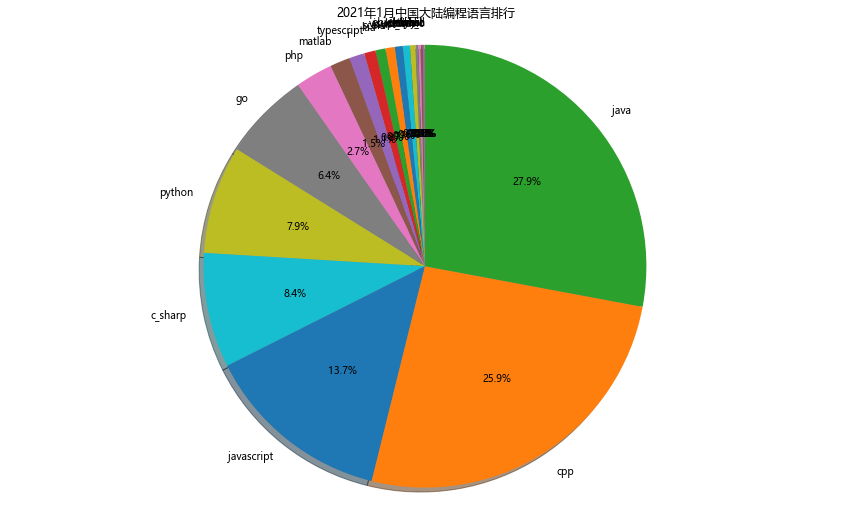

In [44]:
data_pl=data_pl.sort_values(by='百分比')

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = data_pl['pl_']
sizes = data_pl['百分比']
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(15, 9))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"{year}年{month}月中国大陆编程语言排行")
plt.show()